# EuroSAT Baseline Deep Models

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

%matplotlib inline

## Load dataset

In [2]:
def load_eurosat_dataset(data_dir="data"):
    data_path = Path(data_dir)

    # Get all class directories
    class_dirs = [d for d in data_path.iterdir() if d.is_dir()]
    class_names = sorted([d.name for d in class_dirs])

    print(f"Found {len(class_names)} classes: {class_names}")

    images = []
    labels = []

    # Load images from each class
    for class_idx, class_name in enumerate(class_names):
        class_path = data_path / class_name
        image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png"))

        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_path in image_files:
            try:
                # Load image
                img = Image.open(img_path)
                img_array = np.array(img)

                # Store image and label
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    data = np.array(images)
    labels = np.array(labels)

    print(f"\nDataset loaded successfully!")
    print(f"Total images           : {len(data)}")
    print(f"Data shape             : {data.shape}")
    print(f"Labels shape           : {labels.shape}")

    return data, labels, class_names


# Load the dataset
data, labels, class_names = load_eurosat_dataset("data")

Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Loading 3000 images from AnnualCrop...
Loading 3000 images from Forest...
Loading 3000 images from HerbaceousVegetation...
Loading 2500 images from Highway...
Loading 2500 images from Industrial...
Loading 2000 images from Pasture...
Loading 2500 images from PermanentCrop...
Loading 3000 images from Residential...
Loading 2500 images from River...
Loading 3000 images from SeaLake...

Dataset loaded successfully!
Total images           : 27000
Data shape             : (27000, 64, 64, 3)
Labels shape           : (27000,)


## Data preprocessing

In [3]:
# Normalize pixel values to [0, 1]
X = data.astype("float32") / 255.0
y = labels

print(f"Data shape             : {X.shape}")
print(f"Data dtype             : {X.dtype}")
print(f"Data range             : [{X.min():.2f}, {X.max():.2f}]")
print(f"Number of classes      : {len(class_names)}")

Data shape             : (27000, 64, 64, 3)
Data dtype             : float32
Data range             : [0.00, 1.00]
Number of classes      : 10


## Data split

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size      : {X_train.shape[0]} samples")
print(f"Test set size          : {X_test.shape[0]} samples")
print(f"Image shape            : {X_train.shape[1:]}")
print(f"Number of classes      : {len(class_names)}")

Training set size      : 21600 samples
Test set size          : 5400 samples
Image shape            : (64, 64, 3)
Number of classes      : 10


## Model training and evaluation

In [5]:
class SparseF1Score(keras.metrics.Metric):
    """F1 Score metric that works with sparse (integer) labels."""

    def __init__(self, num_classes, average="weighted", name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.f1_metric = keras.metrics.F1Score(average=average)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert sparse labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        self.f1_metric.update_state(y_true_one_hot, y_pred, sample_weight)

    def result(self):
        return self.f1_metric.result()

    def reset_state(self):
        self.f1_metric.reset_state()

In [6]:
def evaluate_model(
    model, X_train, X_test, y_train, y_test, model_name, epochs=20, batch_size=32
):
    print(f"\nTraining {model_name}...")

    # Train
    start_time = time.time()
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
    )
    train_time = time.time() - start_time

    # Predict on test set
    start_time = time.time()
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    predict_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print results
    print(f"\nTraining time        : {train_time:.2f} seconds")
    print(f"Prediction time        : {predict_time:.2f} seconds")

    print(f"\nTest Set Performance Metrics:")
    print(f"  Accuracy             : {accuracy:.4f}")
    print(f"  Precision            : {precision:.4f}")
    print(f"  Recall               : {recall:.4f}")
    print(f"  F1-Score             : {f1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    return {
        "model": model,
        "model_name": model_name,
        "history": history,
        "y_pred": y_pred,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "train_time": train_time,
        "predict_time": predict_time,
    }

### 1. Dense Neural Network

In [7]:
# Build Dense Neural Network
dense_model = keras.Sequential(
    [
        layers.Input(shape=(64, 64, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(class_names), activation="softmax"),
    ]
)

dense_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[SparseF1Score(num_classes=len(class_names), average="weighted")],
)


print("Dense Neural Network Architecture:")
dense_model.summary()

Dense Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,794 (6.07 MB)

 Trainable params: 1,590,794 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train Dense Neural Network
dense_results = evaluate_model(
    dense_model, X_train, X_test, y_train, y_test, "Dense Neural Network", epochs=8
)


Training Dense Neural Network...
Epoch 1/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - f1_score: 0.2939 - loss: 1.8349 - val_f1_score: 0.3491 - val_loss: 1.6698
Epoch 2/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.3884 - loss: 1.5859 - val_f1_score: 0.4597 - val_loss: 1.5098
Epoch 3/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.4263 - loss: 1.5121 - val_f1_score: 0.3660 - val_loss: 1.5760
Epoch 4/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.4511 - loss: 1.4548 - val_f1_score: 0.4496 - val_loss: 1.5097
Epoch 5/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.4644 - loss: 1.4255 - val_f1_score: 0.4171 - val_loss: 1.5017
Epoch 6/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.4815 - loss: 1.3870 - val_f1_score: 0.4935 - val_loss: 1.3336
Epoch 7/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.5045 - loss: 1.3418 - val_f1_score: 0.4816 - val_loss: 1.3642
Epoch 8/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.5204 - loss:

### 2. Convolutional Neural Network (CNN)

In [9]:
# Build Convolutional Neural Network
cnn_model = keras.Sequential(
    [
        layers.Input(shape=(64, 64, 3)),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(class_names), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[SparseF1Score(num_classes=len(class_names), average="weighted")],
)


print("Convolutional Neural Network Architecture:")
cnn_model.summary()

Convolutional Neural Network Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,847,386 (7.05 MB)

 Trainable params: 1,847,386 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train Convolutional Neural Network
cnn_results = evaluate_model(
    cnn_model,
    X_train,
    X_test,
    y_train,
    y_test,
    "Convolutional Neural Network",
    epochs=8,
)


Training Convolutional Neural Network...
Epoch 1/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - f1_score: 0.4264 - loss: 1.4950 - val_f1_score: 0.4665 - val_loss: 1.2551
Epoch 2/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - f1_score: 0.6425 - loss: 0.9904 - val_f1_score: 0.6862 - val_loss: 0.9252
Epoch 3/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - f1_score: 0.7337 - loss: 0.7498 - val_f1_score: 0.6903 - val_loss: 0.8687
Epoch 4/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - f1_score: 0.7723 - loss: 0.6349 - val_f1_score: 0.7348 - val_loss: 0.7407
Epoch 5/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - f1_score: 0.7994 - loss: 0.5596 - val_f1_score: 0.7780 - val_loss: 0.6470
Epoch 6/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - f1_score: 0.8187 - loss: 0.5054 - val_f1_score: 0.7676 - val_loss: 0.6673
Epoch 7/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - f1_score: 0.8411 - loss: 0.4425 - val_f1_score: 0.7668 - val_loss: 0.6512
Epoch 8/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - f1_sco

## Model comparison

In [11]:
# Compare all models
results_summary = pd.DataFrame(
    {
        "Model": [
            dense_results["model_name"],
            cnn_results["model_name"],
        ],
        "Test Accuracy": [
            dense_results["accuracy"],
            cnn_results["accuracy"],
        ],
        "Precision": [
            dense_results["precision"],
            cnn_results["precision"],
        ],
        "Recall": [
            dense_results["recall"],
            cnn_results["recall"],
        ],
        "F1-Score": [
            dense_results["f1"],
            cnn_results["f1"],
        ],
        "Train Time (s)": [
            dense_results["train_time"],
            cnn_results["train_time"],
        ],
        "Predict Time (s)": [
            dense_results["predict_time"],
            cnn_results["predict_time"],
        ],
    }
)

print(results_summary.to_string(index=False))

                       Model  Test Accuracy  Precision   Recall  F1-Score  Train Time (s)  Predict Time (s)
        Dense Neural Network       0.528704   0.528990 0.528704  0.511421       18.678274          0.287734
Convolutional Neural Network       0.770926   0.775447 0.770926  0.770186       73.045332          0.845189


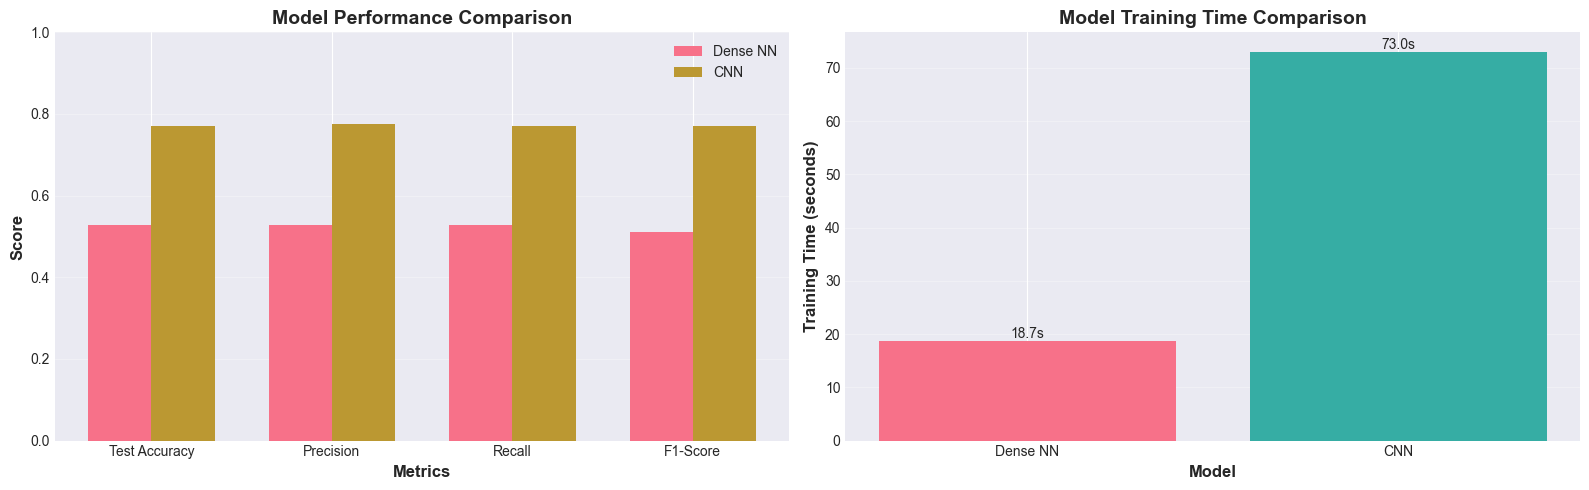

In [12]:
# Performance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Metrics comparison
metrics = ["Test Accuracy", "Precision", "Recall", "F1-Score"]
x = np.arange(len(metrics))
width = 0.35

for i, (results, label) in enumerate(
    [(dense_results, "Dense NN"), (cnn_results, "CNN")]
):
    values = [
        results["accuracy"],
        results["precision"],
        results["recall"],
        results["f1"],
    ]
    axes[0].bar(x + i * width, values, width, label=label)

axes[0].set_xlabel("Metrics", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Score", fontsize=12, fontweight="bold")
axes[0].set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)
axes[0].set_ylim(0, 1)

# Training time comparison
models = ["Dense NN", "CNN"]
train_times = [
    dense_results["train_time"],
    cnn_results["train_time"],
]
colors = sns.color_palette("husl", 2)

bars = axes[1].bar(models, train_times, color=colors)
axes[1].set_xlabel("Model", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Training Time (seconds)", fontsize=12, fontweight="bold")
axes[1].set_title("Model Training Time Comparison", fontsize=14, fontweight="bold")
axes[1].grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}s",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

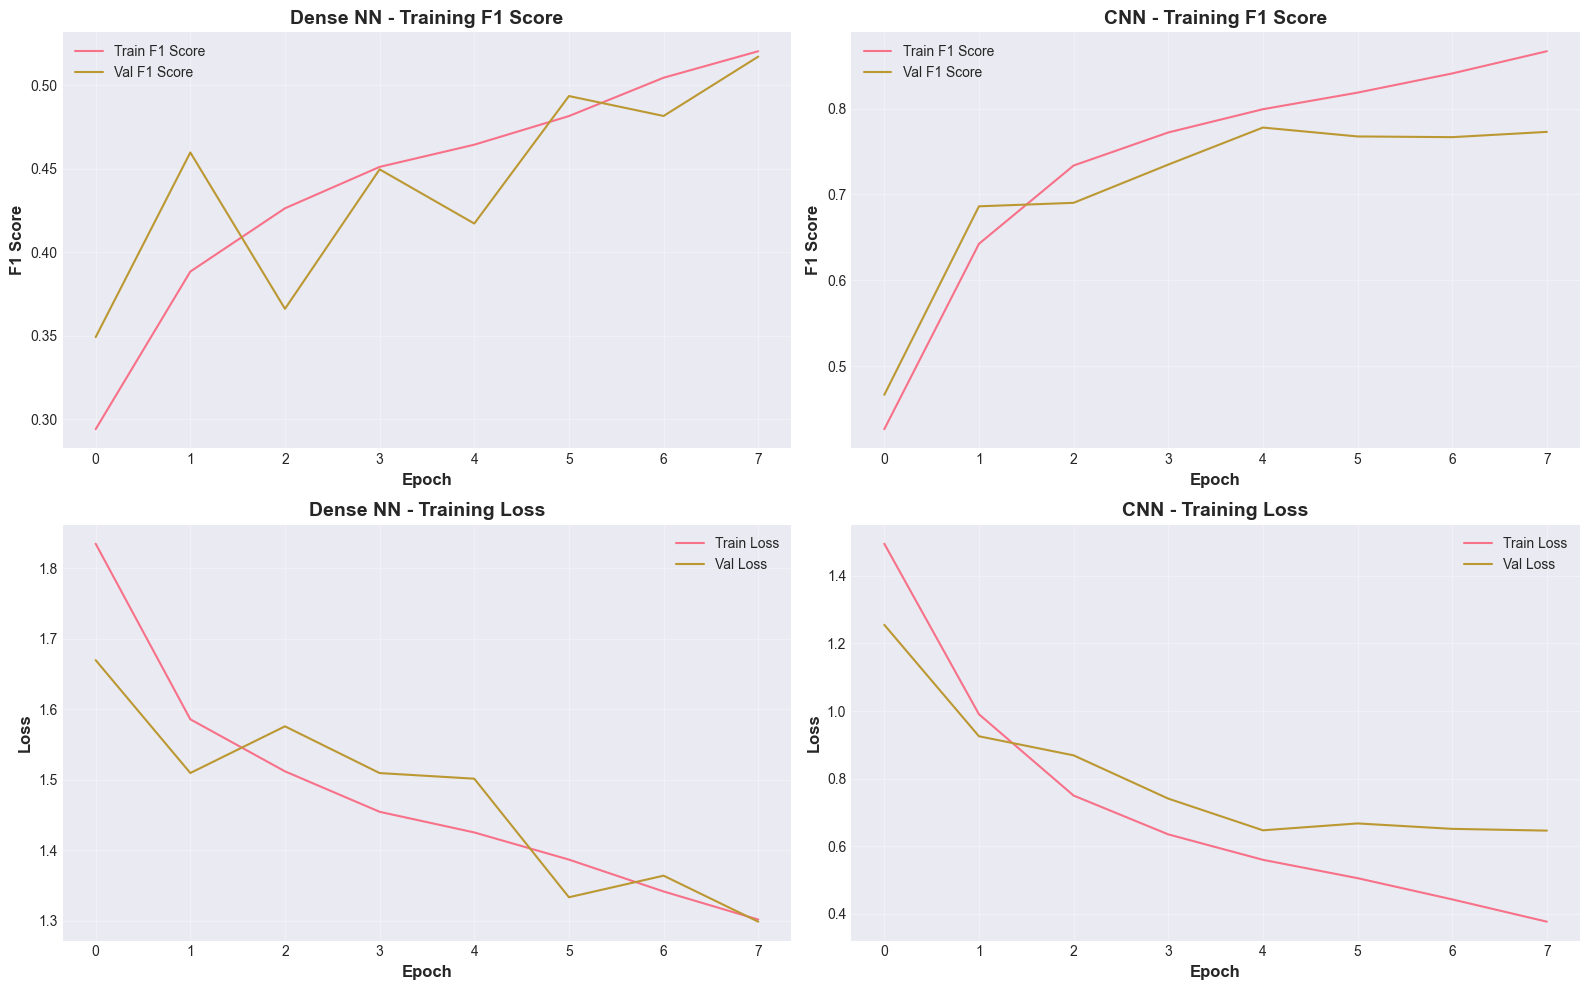

In [13]:
# Training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Dense NN F1 Score
axes[0, 0].plot(dense_results["history"].history["f1_score"], label="Train F1 Score")
axes[0, 0].plot(dense_results["history"].history["val_f1_score"], label="Val F1 Score")
axes[0, 0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("F1 Score", fontsize=12, fontweight="bold")
axes[0, 0].set_title("Dense NN - Training F1 Score", fontsize=14, fontweight="bold")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# CNN F1 Score
axes[0, 1].plot(cnn_results["history"].history["f1_score"], label="Train F1 Score")
axes[0, 1].plot(cnn_results["history"].history["val_f1_score"], label="Val F1 Score")
axes[0, 1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("F1 Score", fontsize=12, fontweight="bold")
axes[0, 1].set_title("CNN - Training F1 Score", fontsize=14, fontweight="bold")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Dense NN loss
axes[1, 0].plot(dense_results["history"].history["loss"], label="Train Loss")
axes[1, 0].plot(dense_results["history"].history["val_loss"], label="Val Loss")
axes[1, 0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Loss", fontsize=12, fontweight="bold")
axes[1, 0].set_title("Dense NN - Training Loss", fontsize=14, fontweight="bold")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# CNN loss
axes[1, 1].plot(cnn_results["history"].history["loss"], label="Train Loss")
axes[1, 1].plot(cnn_results["history"].history["val_loss"], label="Val Loss")
axes[1, 1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Loss", fontsize=12, fontweight="bold")
axes[1, 1].set_title("CNN - Training Loss", fontsize=14, fontweight="bold")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion matrices

In [14]:
def plot_confusion_matrix(y_test, y_pred, class_names, model_name):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Number of samples"},
    )
    plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
    plt.ylabel("True Label", fontsize=12, fontweight="bold")
    plt.title(f"Confusion Matrix - {model_name}", fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

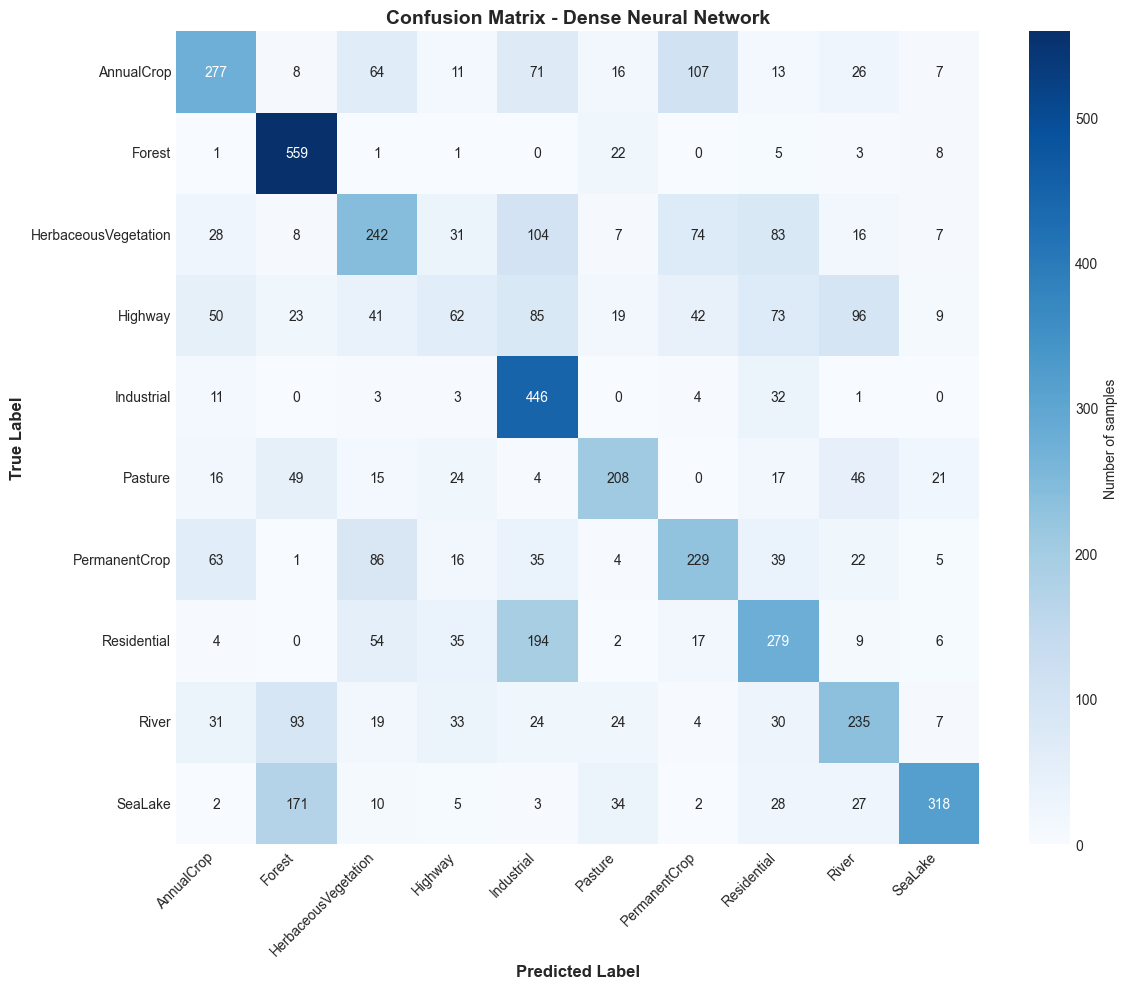

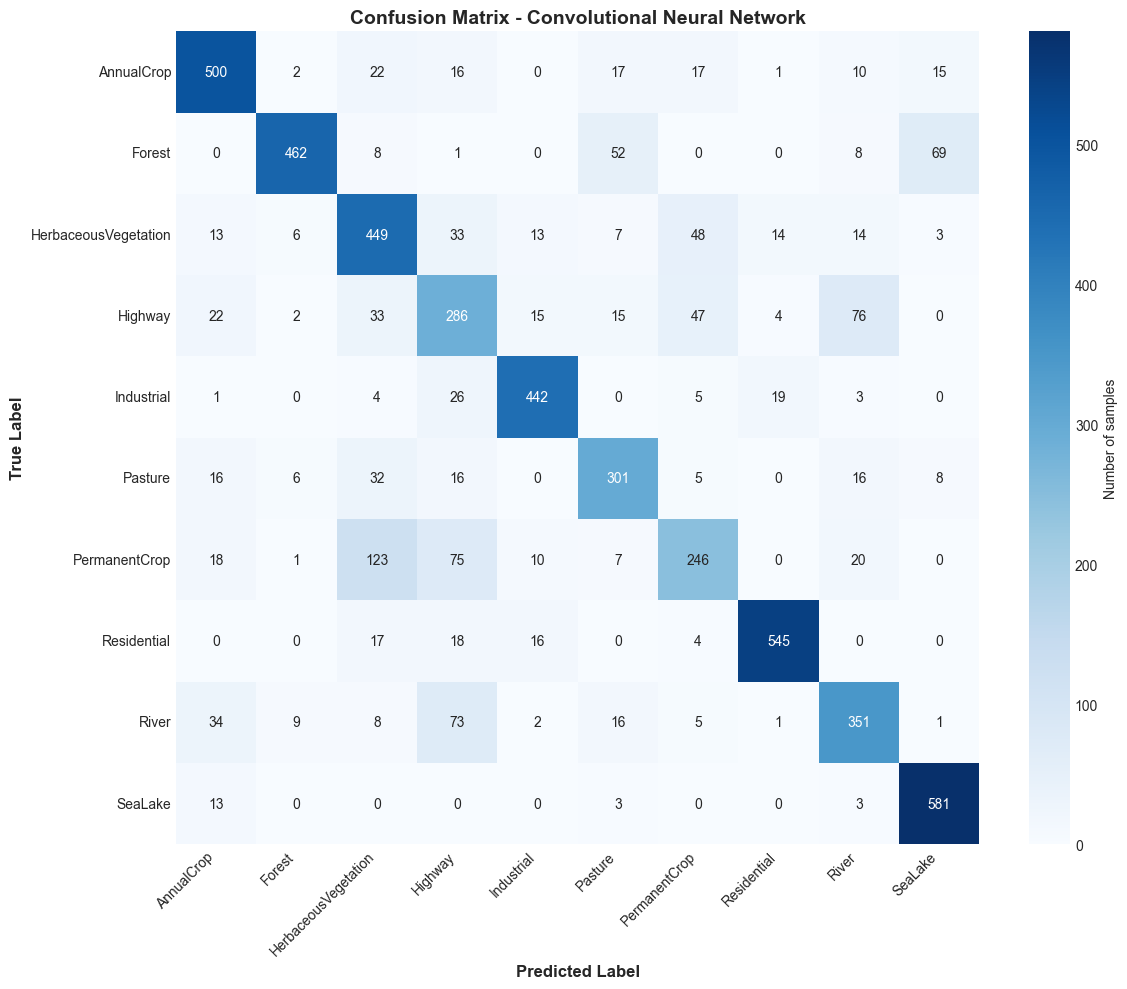

In [15]:
# Confusion matrices for all models
cm_dense = plot_confusion_matrix(
    y_test, dense_results["y_pred"], class_names, "Dense Neural Network"
)
cm_cnn = plot_confusion_matrix(
    y_test, cnn_results["y_pred"], class_names, "Convolutional Neural Network"
)